In [32]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

ratings = ['AAA','AA','A','BBB','BB','B','CCC','default']
transition= np.array([
    [90.81, 8.33, 0.68,0.06, 0.12, 0,0,0],
    [0.70,90.65,7.79,0.64,0.06,0.14,0.02,0],
    [0.09,2.27,91.05,5.52,0.74,0.26,0.01,0.06],
    [0.02,0.33,5.95,86.93,5.30,1.17,0.12,0.18],
    [0.03,0.14,0.67,7.73,80.53,8.84,1.00,1.06],
    [0,0.11,0.24,0.43,6.48,83.46,4.07,5.21],
    [0.22,0,0.22,1.30,2.38,11.24,64.86,19.78],
    [0,0,0,0,0,0,0,100]
]) / 100

print(sum(transition.transpose()))
transition_df = pd.DataFrame(transition, columns=ratings, index=ratings)
display(transition_df)

[1. 1. 1. 1. 1. 1. 1. 1.]


AAA      AA       A     BBB      BB       B     CCC  default
AAA      0.9081  0.0833  0.0068  0.0006  0.0012  0.0000  0.0000   0.0000
AA       0.0070  0.9065  0.0779  0.0064  0.0006  0.0014  0.0002   0.0000
A        0.0009  0.0227  0.9105  0.0552  0.0074  0.0026  0.0001   0.0006
BBB      0.0002  0.0033  0.0595  0.8693  0.0530  0.0117  0.0012   0.0018
BB       0.0003  0.0014  0.0067  0.0773  0.8053  0.0884  0.0100   0.0106
B        0.0000  0.0011  0.0024  0.0043  0.0648  0.8346  0.0407   0.0521
CCC      0.0022  0.0000  0.0022  0.0130  0.0238  0.1124  0.6486   0.1978
default  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   1.0000

In [35]:
pd.DataFrame(np.matmul(transition,transition))


0         1         2         3         4         5         6  \
0  0.825235  0.151314  0.018899  0.002068  0.002188  0.000247  0.000030   
1  0.012774  0.824117  0.141981  0.015724  0.002047  0.002790  0.000389   
2  0.001809  0.041516  0.834125  0.098975  0.015808  0.005880  0.000407   
3  0.000451  0.007315  0.106542  0.763151  0.089983  0.024915  0.002834   
4  0.000567  0.002926  0.016440  0.130336  0.658622  0.147015  0.018231   
5  0.000120  0.002075  0.005053  0.013004  0.107481  0.706918  0.061020   
6  0.003436  0.000433  0.004648  0.022179  0.042594  0.168973  0.425510   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7  
0  0.000018  
1  0.000177  
2  0.001479  
3  0.004809  
4  0.025863  
5  0.104329  
6  0.332226  
7  1.000000

# split matrix

In [31]:
multiyear_transition = transition.copy()

for _ in range(30):
    multiyear_transition = np.matmul(multiyear_transition, transition)
    
pd.DataFrame(multiyear_transition, index=ratings, columns=ratings)

AAA        AA         A       BBB        BB         B       CCC  \
AAA      0.074299  0.229560  0.331860  0.172257  0.068224  0.049974  0.007679   
AA       0.022600  0.159237  0.332803  0.204361  0.088453  0.068377  0.010715   
A        0.012349  0.105002  0.293171  0.211068  0.101119  0.083449  0.013345   
BBB      0.008087  0.072267  0.227995  0.189923  0.102616  0.092227  0.015081   
BB       0.005028  0.043409  0.145612  0.137345  0.085476  0.085012  0.014223   
B        0.002861  0.023236  0.080125  0.083240  0.058361  0.062790  0.010674   
CCC      0.002152  0.014803  0.047745  0.047512  0.032305  0.034220  0.005800   
default  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          default  
AAA      0.066148  
AA       0.113454  
A        0.180497  
BBB      0.291803  
BB       0.483894  
B        0.678713  
CCC      0.815462  
default  1.000000

In [2]:
from scipy.optimize import minimize

class split_transition_matrix():
    """compute the fractional transition matrix
    input the transition matrix, 
    the number of period into which the matrix is divded, 
    the function to minimize (usually least squares fit)
    """
    def __init__(self, transition_matrix, periods, fcn):
        self.m = transition_matrix
        self.p = periods
        self.t_vector = self.m.ravel()
        self.fcn = fcn

    def cumulate_matrix(self):
        self.t = np.reshape(self.t_vector, self.m.shape)
        self.t_cume = cumulate_transitions(self.t, self.p)

    def matrix_diff2(self, a, b):
        return sum(((a - b)*(a - b)).ravel())

    def matrix_vs_cume_diff2(self):
        self.cumulate_matrix()
        return self.matrix_diff2(self.m, self.t_cume)

    def matrix_min(self, t_vector):
        self.t_vector = self.fcn(t_vector)
        return self.matrix_vs_cume_diff2()
    
    def minimize(self):
        """
        compute the fractional multiple of the matrix by
        
        """
        self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})
        return self.res
        
    def get_sub_matrix(self):
        return np.reshape(self.fcn(self.res.x), self.m.shape)  
    
    def cumulate_sub_matrix(self):
        return pd.DataFrame(cumulate_transitions(self.get_sub_matrix(), self.p), index=ratings, columns=ratings)

def cumulate_transitions(t, p):
    """multiply the transition matrix p-times"""
    t_cume = t.copy()
    for i in range(p - 1):
        t_cume = t_cume.dot(t)
    return t_cume

def split_matrix(transition, ratings, periods, fcn):
    """create fractional matrix and display matrix and its fit to the original"""
    t_period = split_transition_matrix(transition, periods, fcn)
    res = t_period.minimize()
    print ('=' * 80)
    print("periods = ", t_period.p, "success = ", res.success, "function value = ",res.fun, 'message = ', res.message)
    display(pd.DataFrame(t_period.get_sub_matrix(), index=ratings, columns=ratings).round(5))
    cumulative_matrix = t_period.cumulate_sub_matrix()
    print("cumulative transition matrix")
    display(cumulative_matrix.round(5))
    print("deviation of cumulative from original transition matrix")
    display((t_period.m - cumulative_matrix).round(5))

    return t_period

## calculate semi-annual, quarterly, and monthly transition matrices

In [3]:
def fcn2(x):
    """minimize the sum of squared values"""
    return pow(x, 2)

t_period2_2 = split_matrix(transition, ratings, 2, fcn2)    # semi-annual
t_period4_2 = split_matrix(transition, ratings, 4, fcn2)    # quarterly
t_period12_2 = split_matrix(transition, ratings, 12, fcn2)  # monthly

C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\2661492707.py:35: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})


periods =  2 success =  True function value =  2.3038450730045937e-08 message =  Optimization terminated successfully.


AAA       AA        A      BBB       BB        B      CCC  \
AAA      0.95286  0.04372  0.00263  0.00020  0.00064  0.00000  0.00000   
AA       0.00367  0.95176  0.04084  0.00276  0.00019  0.00071  0.00010   
A        0.00045  0.01188  0.95346  0.02919  0.00352  0.00121  0.00002   
BBB      0.00009  0.00154  0.03149  0.93121  0.02884  0.00555  0.00053   
BB       0.00015  0.00069  0.00286  0.04221  0.89570  0.04859  0.00519   
B        0.00000  0.00057  0.00118  0.00141  0.03566  0.91177  0.02361   
CCC      0.00125  0.00000  0.00106  0.00712  0.01251  0.06512  0.80436   
default  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

         default  
AAA      0.00000  
AA       0.00000  
A        0.00027  
BBB      0.00075  
BB       0.00461  
B        0.02582  
CCC      0.10866  
default  1.00000

cumulative transition matrix


AAA       AA       A     BBB      BB        B      CCC  default
AAA      0.90810  0.08330  0.0068  0.0006  0.0012  0.00007  0.00001  0.00000
AA       0.00700  0.90650  0.0779  0.0064  0.0006  0.00140  0.00020  0.00004
A        0.00090  0.02270  0.9105  0.0552  0.0074  0.00260  0.00010  0.00060
BBB      0.00020  0.00330  0.0595  0.8693  0.0530  0.01170  0.00120  0.00180
BB       0.00030  0.00140  0.0067  0.0773  0.8053  0.08840  0.01000  0.01060
B        0.00004  0.00110  0.0024  0.0043  0.0648  0.83460  0.04070  0.05210
CCC      0.00220  0.00012  0.0022  0.0130  0.0238  0.11240  0.64860  0.19780
default  0.00000  0.00000  0.0000  0.0000  0.0000  0.00000  0.00000  1.00000

deviation of cumulative from original transition matrix


AAA       AA    A  BBB   BB        B      CCC  default
AAA     -0.00000  0.00000  0.0  0.0  0.0 -0.00007 -0.00001 -0.00000
AA       0.00000 -0.00000  0.0  0.0  0.0  0.00000  0.00000 -0.00004
A        0.00000  0.00000 -0.0 -0.0 -0.0  0.00000 -0.00000  0.00000
BBB     -0.00000  0.00000 -0.0 -0.0 -0.0  0.00000 -0.00000  0.00000
BB       0.00000  0.00000 -0.0 -0.0 -0.0  0.00000  0.00000  0.00000
B       -0.00004  0.00000 -0.0 -0.0  0.0 -0.00000  0.00000  0.00000
CCC      0.00000 -0.00012  0.0  0.0  0.0  0.00000 -0.00000  0.00000
default -0.00000 -0.00000 -0.0 -0.0 -0.0 -0.00000 -0.00000 -0.00000

C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\2661492707.py:35: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})


periods =  4 success =  True function value =  5.0193177868328234e-08 message =  Optimization terminated successfully.


AAA       AA        A      BBB       BB        B      CCC  \
AAA      0.97612  0.02240  0.00110  0.00008  0.00033  0.00000  0.00000   
AA       0.00188  0.97550  0.02091  0.00126  0.00007  0.00036  0.00005   
A        0.00022  0.00608  0.97626  0.01502  0.00171  0.00058  0.00000   
BBB      0.00004  0.00074  0.01620  0.96469  0.01505  0.00268  0.00024   
BB       0.00008  0.00034  0.00129  0.02207  0.94598  0.02549  0.00264   
B        0.00000  0.00029  0.00059  0.00049  0.01872  0.95438  0.01273   
CCC      0.00066  0.00000  0.00052  0.00373  0.00640  0.03509  0.89660   
default  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

         default  
AAA      0.00000  
AA       0.00000  
A        0.00013  
BBB      0.00034  
BB       0.00212  
B        0.01282  
CCC      0.05704  
default  1.00000

cumulative transition matrix


AAA       AA       A     BBB      BB       B      CCC  default
AAA      0.90810  0.08330  0.0068  0.0006  0.0012  0.0001  0.00001  0.00001
AA       0.00700  0.90650  0.0779  0.0064  0.0006  0.0014  0.00019  0.00006
A        0.00090  0.02270  0.9105  0.0552  0.0074  0.0026  0.00010  0.00060
BBB      0.00020  0.00330  0.0595  0.8693  0.0530  0.0117  0.00120  0.00180
BB       0.00030  0.00140  0.0067  0.0773  0.8053  0.0884  0.01000  0.01060
B        0.00006  0.00109  0.0024  0.0043  0.0648  0.8346  0.04070  0.05210
CCC      0.00219  0.00018  0.0022  0.0130  0.0238  0.1124  0.64860  0.19780
default  0.00000  0.00000  0.0000  0.0000  0.0000  0.0000  0.00000  1.00000

deviation of cumulative from original transition matrix


AAA       AA    A  BBB   BB       B      CCC  default
AAA     -0.00000  0.00000  0.0  0.0  0.0 -0.0001 -0.00001 -0.00001
AA       0.00000 -0.00000  0.0  0.0 -0.0  0.0000  0.00001 -0.00006
A        0.00000  0.00000 -0.0 -0.0 -0.0  0.0000 -0.00000  0.00000
BBB     -0.00000  0.00000 -0.0 -0.0 -0.0  0.0000 -0.00000  0.00000
BB       0.00000  0.00000 -0.0 -0.0 -0.0  0.0000  0.00000  0.00000
B       -0.00006  0.00001 -0.0 -0.0 -0.0 -0.0000  0.00000  0.00000
CCC      0.00001 -0.00018  0.0  0.0  0.0  0.0000 -0.00000  0.00000
default -0.00000 -0.00000 -0.0 -0.0 -0.0 -0.0000 -0.00000 -0.00000

C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\2661492707.py:35: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  self.res = minimize(self.matrix_min, self.m, method='Powell',tol=1e-10, options={'maxiter':100000})


periods =  12 success =  True function value =  7.342793224573632e-08 message =  Optimization terminated successfully.


AAA       AA        A      BBB       BB        B      CCC  \
AAA      0.99197  0.00759  0.00032  0.00002  0.00011  0.00000  0.00000   
AA       0.00064  0.99174  0.00708  0.00039  0.00002  0.00012  0.00002   
A        0.00007  0.00206  0.99198  0.00510  0.00056  0.00019  0.00000   
BBB      0.00001  0.00024  0.00551  0.98802  0.00516  0.00087  0.00008   
BB       0.00003  0.00011  0.00040  0.00758  0.98156  0.00877  0.00089   
B        0.00000  0.00010  0.00020  0.00011  0.00645  0.98444  0.00446   
CCC      0.00023  0.00000  0.00017  0.00129  0.00217  0.01230  0.96421   
default  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

         default  
AAA      0.00000  
AA       0.00000  
A        0.00004  
BBB      0.00011  
BB       0.00066  
B        0.00425  
CCC      0.01966  
default  1.00000

cumulative transition matrix


AAA       AA       A     BBB       BB        B      CCC  default
AAA      0.90810  0.08330  0.0068  0.0006  0.00119  0.00012  0.00001  0.00001
AA       0.00700  0.90650  0.0779  0.0064  0.00060  0.00139  0.00019  0.00008
A        0.00090  0.02270  0.9105  0.0552  0.00740  0.00260  0.00011  0.00060
BBB      0.00020  0.00330  0.0595  0.8693  0.05300  0.01170  0.00120  0.00180
BB       0.00030  0.00140  0.0067  0.0773  0.80530  0.08840  0.01000  0.01060
B        0.00007  0.00109  0.0024  0.0043  0.06480  0.83460  0.04070  0.05210
CCC      0.00219  0.00022  0.0022  0.0130  0.02380  0.11240  0.64860  0.19780
default  0.00000  0.00000  0.0000  0.0000  0.00000  0.00000  0.00000  1.00000

deviation of cumulative from original transition matrix


AAA       AA    A  BBB       BB        B      CCC  default
AAA     -0.00000  0.00000  0.0  0.0  0.00001 -0.00012 -0.00001 -0.00001
AA       0.00000 -0.00000  0.0  0.0 -0.00000  0.00001  0.00001 -0.00008
A        0.00000  0.00000 -0.0 -0.0  0.00000  0.00000 -0.00001  0.00000
BBB     -0.00000  0.00000 -0.0 -0.0 -0.00000 -0.00000  0.00000  0.00000
BB       0.00000  0.00000 -0.0 -0.0 -0.00000  0.00000  0.00000  0.00000
B       -0.00007  0.00001 -0.0 -0.0 -0.00000 -0.00000  0.00000  0.00000
CCC      0.00001 -0.00022  0.0  0.0  0.00000  0.00000 -0.00000  0.00000
default -0.00000 -0.00000 -0.0 -0.0 -0.00000 -0.00000 -0.00000 -0.00000

In [4]:
print(t_period2_2.get_sub_matrix())
dir(t_period2_2)

[[9.52858050e-01 4.37189445e-02 2.62629785e-03 1.99386890e-04
  6.35634875e-04 2.37380831e-23 1.77613355e-21 2.23483128e-21]
 [3.66545724e-03 9.51761461e-01 4.08362149e-02 2.76028241e-03
  1.88246269e-04 7.06958316e-04 1.00921538e-04 8.31554411e-22]
 [4.47541291e-04 1.18791234e-02 9.53458433e-01 2.91917109e-02
  3.52173468e-03 1.21011130e-03 2.08231384e-05 2.69929372e-04]
 [9.29732486e-05 1.53933247e-03 3.14896329e-02 9.31207682e-01
  2.88379813e-02 5.54816167e-03 5.29177852e-04 7.54759952e-04]
 [1.54237600e-04 6.85329207e-04 2.85511643e-03 4.22076943e-02
  8.95697888e-01 4.85893775e-02 5.19420687e-03 4.61478039e-03]
 [2.19464605e-22 5.66117116e-04 1.18263057e-03 1.40570648e-03
  3.56631171e-02 9.11767639e-01 2.36077560e-02 2.58236905e-02]
 [1.24820022e-03 7.79419073e-22 1.05761639e-03 7.11538252e-03
  1.25101206e-02 6.51183428e-02 8.04359336e-01 1.08656303e-01]
 [1.24714608e-19 2.36780452e-20 2.33095262e-08 1.90706960e-09
  1.13828773e-09 1.06864215e-09 9.47444386e-16 1.00000000e+00]]

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cumulate_matrix',
 'cumulate_sub_matrix',
 'fcn',
 'get_sub_matrix',
 'm',
 'matrix_diff2',
 'matrix_min',
 'matrix_vs_cume_diff2',
 'minimize',
 'p',
 'res',
 't',
 't_cume',
 't_vector']

In [5]:
# double check the row  and column sums to insure that they equal 1

print(pd.DataFrame(t_period12_2.get_sub_matrix()).sum(axis=0))
print(pd.DataFrame(t_period12_2.get_sub_matrix()).sum(axis=1))

0    0.992953
1    1.001838
2    1.005651
3    1.002513
4    0.996018
5    1.006695
6    0.969658
7    1.024718
dtype: float64
0    1.000012
1    1.000005
2    1.000000
3    1.000000
4    0.999999
5    1.000005
6    1.000020
7    1.000000
dtype: float64


In [6]:
display(pd.DataFrame(t_period2_2.t).round(5))

0        1        2        3        4        5        6        7
0  0.95286  0.04372  0.00263  0.00020  0.00064  0.00000  0.00000  0.00000
1  0.00367  0.95176  0.04084  0.00276  0.00019  0.00071  0.00010  0.00000
2  0.00045  0.01188  0.95346  0.02919  0.00352  0.00121  0.00002  0.00027
3  0.00009  0.00154  0.03149  0.93121  0.02884  0.00555  0.00053  0.00075
4  0.00015  0.00069  0.00286  0.04221  0.89570  0.04859  0.00519  0.00461
5  0.00000  0.00057  0.00118  0.00141  0.03566  0.91177  0.02361  0.02582
6  0.00125  0.00000  0.00106  0.00712  0.01251  0.06512  0.80436  0.10866
7  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  1.00000

# cumulative default probability

C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\1913234875.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  defaults = defaults.append(transition_x['default'])
C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\1913234875.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  defaults = defaults.append(transition_x['default'])
C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\1913234875.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  defaults = defaults.append(transition_x['default'])
C:\Users\Elliot\AppData\Local\Temp\ipykernel_2092\1913234875.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  defaults = defaults.append(trans

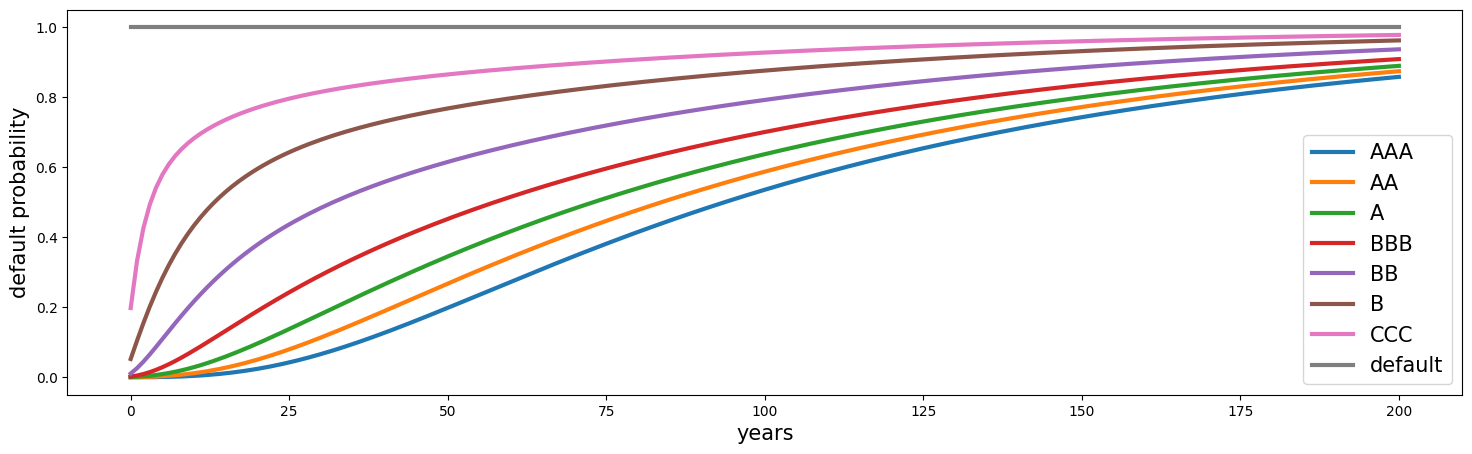

In [7]:
transition_x = transition_df.copy()
defaults = transition_x['default']
n = 200
for _ in range(n):
    transition_x = transition_x.dot(transition_df)
    defaults = defaults.append(transition_x['default'])
    
defaults_df = pd.DataFrame(np.reshape(np.array(defaults),(n+1,8)), 
                           columns=transition_df.columns)
plt.figure(figsize=(18,5))
plt.plot(defaults_df, linewidth=3)
plt.legend(defaults_df.columns,fontsize=15)
plt.xlabel('years',fontsize=15)
plt.ylabel('default probability',fontsize=15)
plt.show()

In [8]:
print ('*' * 80)

********************************************************************************


In [9]:
import pickle
#pickle.dump({"2":t_period2, "4":t_period4, "12":t_period12}, open('split_transitions1.pkl','wb'))
pickle.dump({"2":t_period2_2, "4":t_period4_2, "12":t_period12_2}, open('split_transitions_2.pkl','wb'))

In [10]:
splits = pickle.load( open('split_transitions_2.pkl','rb'))
np.array(dir(splits['2']))

array(['__class__', '__delattr__', '__dict__', '__dir__', '__doc__',
       '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__',
       '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__',
       '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__',
       '__repr__', '__setattr__', '__sizeof__', '__slotnames__',
       '__str__', '__subclasshook__', '__weakref__', 'cumulate_matrix',
       'cumulate_sub_matrix', 'fcn', 'get_sub_matrix', 'm',
       'matrix_diff2', 'matrix_min', 'matrix_vs_cume_diff2', 'minimize',
       'p', 'res', 't', 't_cume', 't_vector'], dtype='<U20')

In [11]:
t2 = np.reshape(splits['2'].t,(8,8))
display(pd.DataFrame(cumulate_transitions(t2, 2)).round(5))

0        1       2       3       4        5        6        7
0  0.90810  0.08330  0.0068  0.0006  0.0012  0.00007  0.00001  0.00000
1  0.00700  0.90650  0.0779  0.0064  0.0006  0.00140  0.00020  0.00004
2  0.00090  0.02270  0.9105  0.0552  0.0074  0.00260  0.00010  0.00060
3  0.00020  0.00330  0.0595  0.8693  0.0530  0.01170  0.00120  0.00180
4  0.00030  0.00140  0.0067  0.0773  0.8053  0.08840  0.01000  0.01060
5  0.00004  0.00110  0.0024  0.0043  0.0648  0.83460  0.04070  0.05210
6  0.00220  0.00012  0.0022  0.0130  0.0238  0.11240  0.64860  0.19780
7  0.00000  0.00000  0.0000  0.0000  0.0000  0.00000  0.00000  1.00000

In [12]:
defaults_df

AAA        AA         A       BBB        BB         B       CCC  \
0    0.000000  0.000000  0.000600  0.001800  0.010600  0.052100  0.197800   
1    0.000018  0.000177  0.001479  0.004809  0.025863  0.104329  0.332226   
2    0.000075  0.000535  0.002712  0.009059  0.044354  0.154395  0.425690   
3    0.000190  0.001082  0.004354  0.014506  0.064943  0.201204  0.492436   
4    0.000379  0.001834  0.006443  0.021060  0.086762  0.244349  0.541554   
..        ...       ...       ...       ...       ...       ...       ...   
196  0.851242  0.868091  0.884188  0.904478  0.933777  0.960512  0.976917   
197  0.853000  0.869650  0.885557  0.905607  0.934560  0.960979  0.977190   
198  0.854738  0.871191  0.886910  0.906723  0.935334  0.961440  0.977460   
199  0.856455  0.872714  0.888247  0.907826  0.936098  0.961896  0.977726   
200  0.858152  0.874219  0.889568  0.908916  0.936854  0.962346  0.977989   

     default  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  
..       ...  
196      1.0  
197      1.0  
198      1.0  
199      1.0  
200      1.0  

[201 rows x 8 columns]